In [1]:
print('Hello World')

Hello World


In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

import nbconvert

## Hello!
This is a 'revisitation' of my thesis back in 2019-2020. Basically, I was trying to see the relationship between 'gardening' and 'food security.'
    
Initially, for the research design, I had to identify how to measure either (what makes an individual '_food secure_,' what constitutes as a '_garden_,' etc.). For food security, I have decided to use the Household Food Insecurity Access Scale (HFIAS) as it is reputable (used by the United Nations) and '_cheap_' to administer. The HFIAS' weakness is that it is based on just one '_pillar_' of food security which is access. This pillar is quite subjective since it does not take into account the nutritional content of the food. As long as respondents '_feel_' that they can easily access '_food_,' it does not matter whether '_food_' in this instance is adequately healthy or not.
    
For gardens, it was a bit trickier since respondents in that particular area (Kapatagan, Digos City) often referred to large-scale agricultural productions as 'gardens' if it produced vegetables. Combining the different definitions of '_gardens_' found in literature, I have settled with:
>"A garden is a form of __small__ scale food production system of fruits and vegetables, __near homesteads__ which __requires labor from the household__."

This puts emphasis on '__small__,' '__near homesteads__,' and '__requires labor from the household__,' thereby invalidating most large-scale agricultural productions since it is often NOT small nor found near the home of respondents, and most likely required outside labor.

### Some of you might already be wondering...
Why is the food security score binary when in the HFIAS, it specified 4 categories for food security (Food Secure, Mildly Food Insecure, Moderately Food Insecure, and Severely Food Insecure). 

First, most (92%) of my respondeents fell on the first two categories. This would mean that if I were to perform my regression now, the model would most likely struggle to differentiate what makes a respondent fall on categories 3 and 4 since there's not enough data to train the model on. Today, one can probably get away with upsampling BUT it just does not _feel_ right with me :/

Second, performing a Binary regression is '_easier_' and still probably sound in this scenario. After all, those who fell on category 2 (Mildly Food Insecure) _felt_ they were at risk of food insecurity and it would probably be prudent to classify these as 'food insecure.'

In [5]:
df = pd.read_csv('Thesis Data.csv')
df.head()

,Food Secure,Age,Sex,Household Size,18&below,60&above,Annual Income,Garden,Garden Size,No. of Crops,Top 3 Crops,Garden Annual Income
0,0,33,0,5,2,0,182500,1,4.0,5.0,"Alugbati, Luya, Sibuyas",0.0
1,0,38,0,6,4,0,60000,1,6.0,3.0,"Sibuyas, Alugbati, Luya",0.0
2,1,33,0,4,2,0,1825000,0,NaN,NaN,NaN,NaN
3,1,49,0,6,2,0,1440000,0,NaN,NaN,NaN,NaN
4,0,29,0,4,2,0,127750,1,1.0,1.0,Alugbati,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Food Secure           146 non-null    int64  
 1   Age                   146 non-null    int64  
 2   Sex                   146 non-null    int64  
 3   Household Size        146 non-null    int64  
 4   18&below              146 non-null    int64  
 5   60&above              146 non-null    int64  
 6   Annual Income         146 non-null    int64  
 7   Garden                146 non-null    int64  
 8   Garden Size           81 non-null     float64
 9   No. of Crops          81 non-null     float64
 10  Top 3 Crops           81 non-null     object 
 11  Garden Annual Income  81 non-null     float64
dtypes: float64(3), int64(8), object(1)
memory usage: 13.8+ KB


### Data Cleaning, Transformation of Variables...
1. Log transformation(to base 10) of income to reduce the skew of income (initially, the distribution was skewed to right because very few respondents earned high income; just like in real-life)

2. Transformation of 'Food Secure' and 'Garden' variables to category since it was _misclassified_ as integers. This would later make it easier for visualizations.

3. Created a new binary variable for presence/absence of minor/senior citizens. I hypothesized that the presence/absence of a minor/senior citizen (aka dependents) would contribute to a household's food security score. The subsequent increase/decrease in either would probably _still_ contribute BUT at diminishing returns. In summary, I hedged that it is the presence/absence of either AND not how many that makes/breaks the food security score.

4. Check for duplicated rows. None were found.

5. Masking outliers for 'income' and 'garden size.' Later on the notebook, I will be alternating between datasets with and w/out outliers depending on the context of the story trying to be told by the visualization.

6. Create a new data frame for the 'string' of 'Top 3 Crops.' After that, I had to clean and remove whitespaces, check and replace for duplicates. This data frame will be used to identify which crops are most commonly cultivated in gardens within Kapatagan, Digos City.

In [8]:
# transform to categories #
fs_cat = pd.CategoricalDtype(categories=[0,1],ordered=True)
g_cat = pd.CategoricalDtype(categories=[0,1],ordered=True)
df['Food Secure'] = df['Food Secure'].astype(fs_cat)
df['Garden'] = df['Garden'].astype(g_cat)

# log income #
df['log_income'] = np.log10(df['Annual Income'])

# create new categorical variables #
# with minor #
df['minor'] = np.where(df['18&below']>0,1,0)
m_cat = pd.CategoricalDtype(categories=[0,1],ordered=True)
df['minor'] = df['minor'].astype(m_cat)

# wtih senior #
df['senior'] = np.where(df['60&above']>0,1,0)
s_cat = pd.CategoricalDtype(categories=[0,1],ordered=True)
df['senior'] = df['senior'].astype(s_cat)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Food Secure           146 non-null    category
 1   Age                   146 non-null    int64   
 2   Sex                   146 non-null    int64   
 3   Household Size        146 non-null    int64   
 4   18&below              146 non-null    int64   
 5   60&above              146 non-null    int64   
 6   Annual Income         146 non-null    int64   
 7   Garden                146 non-null    category
 8   Garden Size           81 non-null     float64 
 9   No. of Crops          81 non-null     float64 
 10  Top 3 Crops           81 non-null     object  
 11  Garden Annual Income  81 non-null     float64 
 12  log_income            146 non-null    float64 
 13  minor                 146 non-null    category
 14  senior                146 non-null    category
dtypes: cat

In [10]:
# check for duplicates #
df[df.duplicated()]

,Food Secure,Age,Sex,Household Size,18&below,60&above,Annual Income,Garden,Garden Size,No. of Crops,Top 3 Crops,Garden Annual Income,log_income,minor,senior


In [11]:
# mask outliers #
# income #
lower_limit = df['Annual Income'].mean() - 3*df['Annual Income'].std()
upper_limit = df['Annual Income'].mean() + 3*df['Annual Income'].std()
df_nofliers = df[(df['Annual Income']>lower_limit)&(df['Annual Income']<upper_limit)]

# garden size #
ll_gsize = df['Garden Size'].mean() - 3*df['Garden Size'].std()
ul_gsize = df['Garden Size'].mean() + 3*df['Garden Size'].std()
df_nofliers = df_nofliers[(df_nofliers['Garden Size'].isna()==True)|(df_nofliers['Garden Size']>ll_gsize)&(df_nofliers['Garden Size']<ul_gsize)]
df_nofliers = df_nofliers[(df_nofliers['Garden Size']<25)|(df_nofliers['Garden Size'].isna()==True)]

# no. of crops #
df_nofliers = df_nofliers[(df_nofliers['No. of Crops']<=5)|(df_nofliers['No. of Crops'].isna()==True)]

In [12]:
# adding new columns, transforming binary to strings #
df_nofliers['Garden_String'] = df_nofliers['Garden'].astype('str')
df_nofliers['Garden_String'] = df_nofliers['Garden_String'].replace('0','No Garden')
df_nofliers['Garden_String'] = df_nofliers['Garden_String'].replace('1','With Garden')
df_nofliers['Food_Secure_String'] = df_nofliers['Food Secure'].astype('str')
df_nofliers['Food_Secure_String'] = df_nofliers['Food_Secure_String'].replace('0','Food Insecure')
df_nofliers['Food_Secure_String'] = df_nofliers['Food_Secure_String'].replace('1','Food Secure')

In [13]:
# data cleaning top 3 crops column #
df_garden = df_nofliers[df_nofliers.isnull().any(axis=1)==False] # filter those with garden #
df_garden = df_garden['Top 3 Crops'].reset_index(drop=True) # isolate top 3 crops column #
crops = df_garden.str.split(',',expand=True) # split to columns #

# remove whitespaces #
crops[0] = crops[0].str.strip()
crops[1] = crops[1].str.strip()
crops[2] = crops[2].str.strip()

# create columns with count values per crop #
crop_0 = crops.value_counts(0).reset_index()
crop_1 = crops.value_counts(1).reset_index().rename(columns={1:0,'count':'count_1'})
crop_2 = crops.value_counts(2).reset_index().rename(columns={2:0,'count':'count_2'})

# merge columns to a single df #
crop_01 = pd.merge(crop_0,crop_1,on=0,how='outer')
crop_012 = pd.merge(crop_01,crop_2,on=0,how='outer')

# fill nan values with zero #
crop_012 = crop_012.fillna(0)

# combine sili & siling labuyo; alugbate and alugbati #
crop_012 = crop_012.drop(0) # drop alugbate #
crop_012.loc[1,'count'] = 23 + 1 # add alugbate to alugbati #
crop_012 = crop_012.drop(17) # drop sili #
crop_012.loc[18,'count'] = 0 + 7 # add sili to siling labuyo #

# rename column 0; create new column for total #
crop_012 = crop_012.rename(columns={0:'crop'})
crop_012['total'] = crop_012['count'] + crop_012['count_1'] + crop_012['count_2']
crop_012 = crop_012[['crop','total']]

# sort values; crop df is now ready! #
crop_012 = crop_012.sort_values('total',ascending=False)
crop_012.head()

,crop,total
1,Alugbati,37.0
13,Sibuyas,29.0
16,Talong,20.0
12,Sayote,9.0
9,Okra,8.0


### First Visualization... of Many
These are the most common crops that are cultivated in gardens within Kapatagan, Digos City. To quote myself from my thesis:
>"These crops are potentially the most common because these are well adapted to Kapatagan’s environment. Other reasons include its low-maintenance nature (neither labor nor capital intensive), ease of propagation (e.g. stem cuttings), its high tendency to be incorporated towards the Filipino cuisine, overall usefulness and “zero-waste.
>
>For example: Alugbati(_Basella alba_), Sibuyas(_Allium cepa_), Sayote(_Sechium edule_), Gabi(_Colocasia esculenta_), Okra(_Abelmoschus esculentus_), Sili (_Capsilum frutescens_), Kamunggay (_Moringa oleifera_), Kamote Tops (_Ippomoea batatas_), Kangkong (_Ipomea aquatic_), and Ampalaya (_Momordica charantia_) are easily incorporated to Filipino meals (particularly soups and sauté) and at the same time, most of their parts are edible (from leaves to fruit)."

C:\Users\Barba\AppData\Local\Temp\ipykernel_14116\962292633.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Text(0.5, 1.0, 'Most Common Garden Crops')

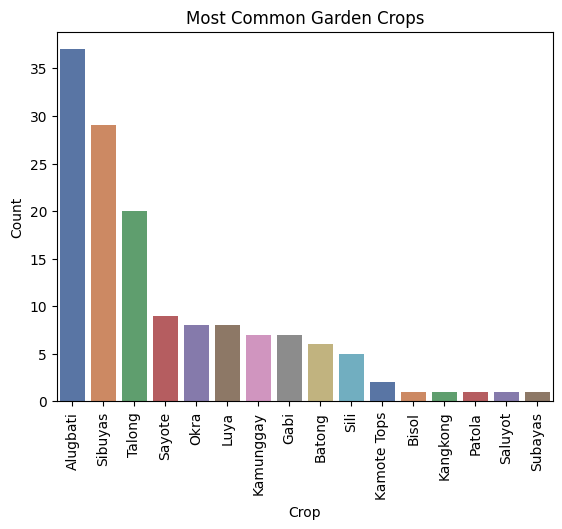

In [96]:
# most common garden crops #
sns.barplot(
    data=crop_012,
    hue='crop',
    y='total',
    leg
)
plt.xticks(rotation=90)
plt.xlabel('Crop')
plt.ylabel('Count')
plt.title('Most Common Garden Crops')

### Gardens: What do they look like? 
These visualizations illustrate what 'gardens' in Kapatagan, Digos City might look like:
1. Home gardens are a common occurrence in Kapatagan, Digos city wherein 57% of the total number of respondents had a garden. Home gardens had a mean size of 22 square meters (4.33 w/out outliers), with the most common being 4 square meters(!)

2. It only cultivates a small cluster of crops ranging from one to six varieties at most, with the average being three crops(!) The most common crops are Alugbati, Sibuyas, Talong, Sayote, Okra and Gabi respectively. These crops are potentially well adapted to Kapatagan’s climate and such are easy to propagate.

Text(0.5, 1.0, 'Garden Sizes in Kapatagan (sq m.)')

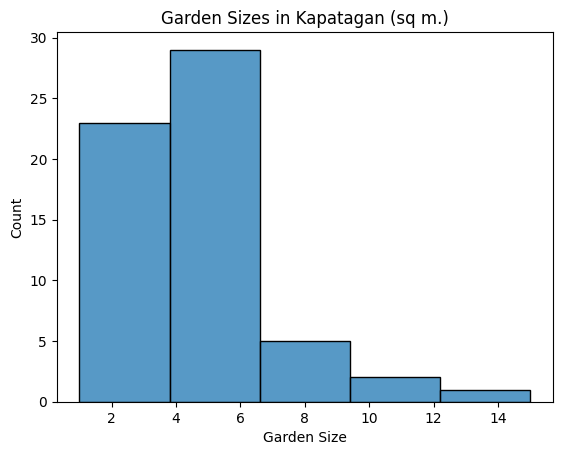

In [17]:
sns.histplot(
    data=df_nofliers,
    x='Garden Size',
    bins=5,
)
plt.title('Garden Sizes in Kapatagan (sq m.)')

Text(0.5, 1.0, 'No. of Crops within the Garden')

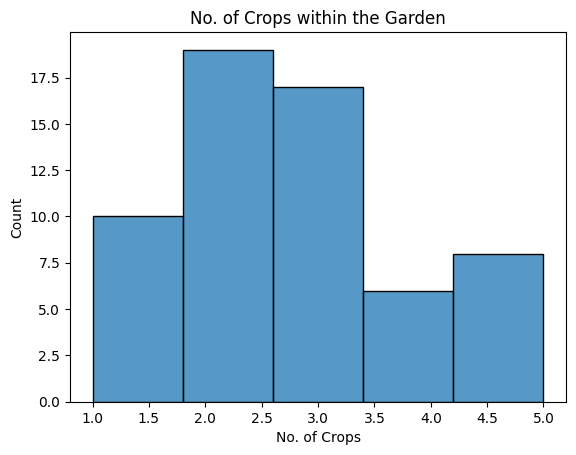

In [18]:
sns.histplot(
    data=df_nofliers,
    x='No. of Crops',
    bins=5,
    binrange=(1,5)
)
plt.title('No. of Crops within the Garden')

In [19]:
#summary statistics: gardens #
garden = df_nofliers[df_nofliers.isnull().any(axis=1)==False]
garden[['Garden Size','No. of Crops']].agg(['mean','min','max'])

,Garden Size,No. of Crops
mean,4.333333,2.716667
min,1.000000,1.000000
max,15.000000,5.000000


### Food Security and Relationships
1. __Income is King__: as income increases, the proportion of food insecure households decreases. Income (just like food) is a resource that can easily be transformed to food if the need arises.
   
2. __Gardens as Indicators of Food Insecurity__: surprisingly(!) food insecurity is more prevalent among garden practitioning households rather than non-practitioning households. There are multiple possible explanations for this:

    1. Food insecure households resort to gardening as a 'defensive mechanism' to combat their food insecurity which would explain why gardens are closely related to food insecure households.
   
    2. Food secure households often have higher income which means that they can 'afford' to not indulge in gardening.
  
    3. There is an inherent opportunity cost that comes along with tending a garden. Instead of gardening, an individual or member of the household might pursue employment. Whereas, households with lower opportunity costs might opt for gardening to 'stave off' food insecurity, other households (with "better" opportunities) opt for employment.

3. __Gardens Beat Non-Practitioners at Low Income__: at annual household incomes below Php 200,000, those with gardens performed slightly better (albeit not statistically significant) than those without.

4. __Household Sizes Do Not Seem to Differentiate__: the proportion of food secure and food insecure do not seem to change across smaller and larger household sizes. While yes, larger household sizes might struggle to '_access_' food due to having more mouths to feed, it also benefits from higher income (due to more working individuals).

5. __Presence of Minors as Indicators of Food Insecurity__: as hypothesized, food insecurity is more prevalent in households with minors in contrast with those who do not. Minors, most likely, do not contribute to the household income and are dependent on other members. This could prove strenuous to limited-income households.

6. __Presence of Senior Citizens Not So Conclusive__: contrary to my hypothesis, the presence/absence of senior citizen do not seem to indicate whether a household is food secure or not. Still, this is likely due to senior citizens being capable of providing for themselves (either through employment or pension benefits) unlike children/minors who are entirely dependent on other members.

In [21]:
# initializing the data frame to be used in succeeding sections #
t_df = df[['Food Secure', 'Household Size', 'minor', 'senior',
           'Annual Income', 'log_income', 'Garden']]
t_df.shape

(146, 7)

Text(0.5, 1.0, 'Annual Income in Relation to Food Security Scores')

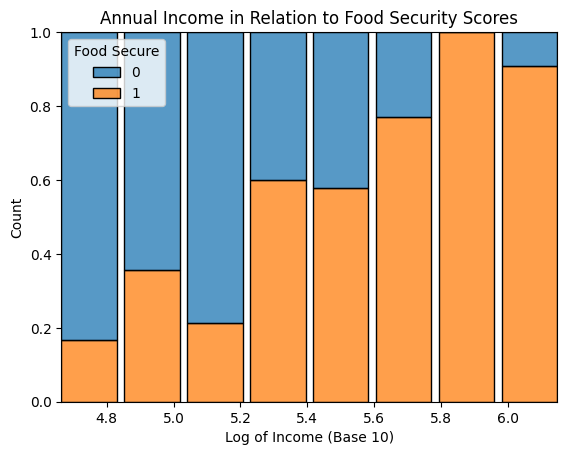

In [22]:
sns.histplot(
    data=df_nofliers,
    hue='Food Secure',
    x='log_income',
    multiple='fill',
    shrink=0.88
)
plt.xlabel('Log of Income (Base 10)')
plt.title('Annual Income in Relation to Food Security Scores')

Text(0.5, 1.0, 'Food Security Scores:\nGarden vs. w/out Garden')

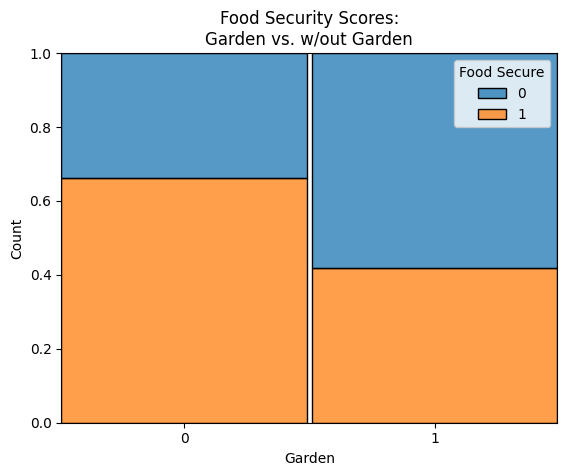

In [23]:
sns.histplot(
    data=t_df,
    hue='Food Secure',
    x='Garden',
    multiple='fill',
    shrink=0.98
)
plt.xticks([0,1])
plt.title('Food Security Scores:\nGarden vs. w/out Garden')

Text(0.5, 1.0, 'Food Security Scores:\nGarden vs. w/out Garden (Low Income)')

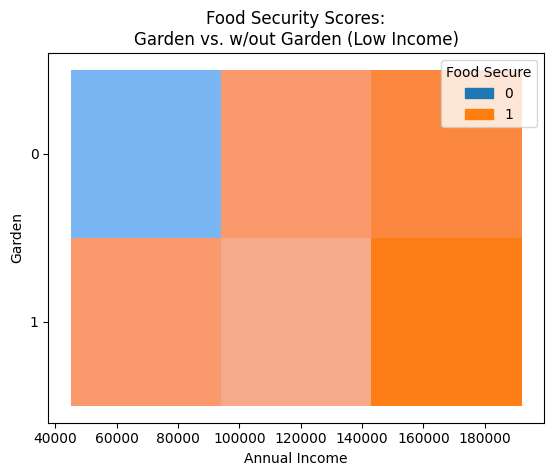

In [24]:
sns.histplot(
    data=t_df[t_df['Annual Income']<=200000],
    x='Annual Income',
    y='Garden',
    hue='Food Secure',
    bins=3,
)
plt.yticks([0,1])
plt.title('Food Security Scores:\nGarden vs. w/out Garden (Low Income)')

In [25]:
# chi-square test of indenpendence between food secure, food insecure, garden, wout garden #
g_fs = pd.DataFrame(t_df[['Food Secure','Garden']].value_counts()).unstack()
res = stats.contingency.chi2_contingency(g_fs)
print('P-Value (Garden and Food Security): ','%.2f' %res.pvalue)

P-Value (Garden and Food Security):  0.01


In [26]:
# same chi-square test but filtered for low income #
ga_fs = pd.DataFrame(t_df[t_df['Annual Income']<=200000][['Food Secure','Garden']].value_counts()).unstack()
res = stats.contingency.chi2_contingency(ga_fs)
print('P-Value (Income < 200,000): ','%.2f' %res.pvalue)

P-Value (Income < 200,000):  0.39


Text(0.5, 1.0, 'Household Sizes in Relation to Food Security Scores')

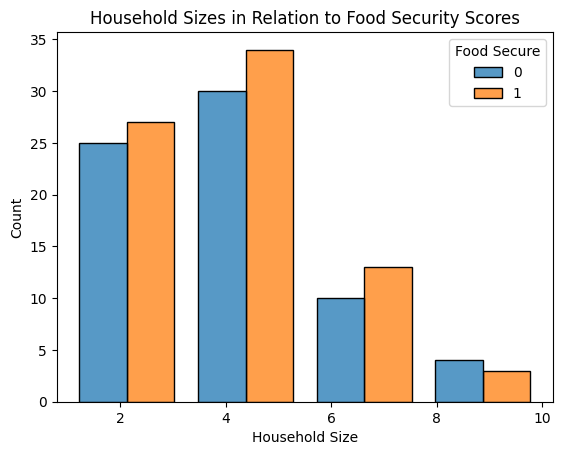

In [27]:
sns.histplot(
    data=t_df,
    x='Household Size',
    hue='Food Secure',
    multiple='dodge',
    bins=4,
    shrink=0.80
)
plt.title('Household Sizes in Relation to Food Security Scores')

Text(0.5, 1.0, 'Presence/Absence of Minor\nin Relation to Food Security Scores')

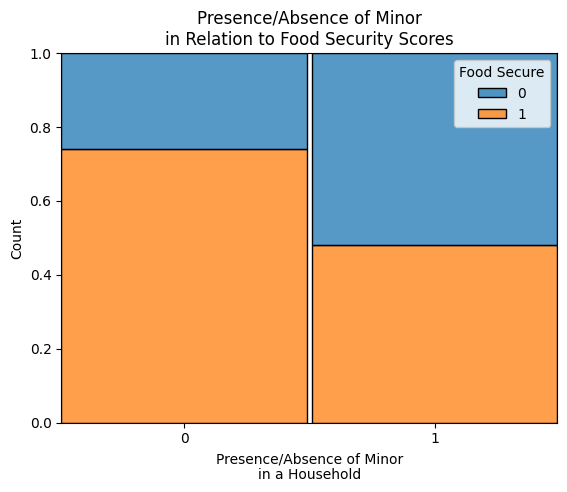

In [28]:
sns.histplot(
    data=t_df,
    x='minor',
    hue='Food Secure',
    multiple='fill',
    shrink=0.98
)
plt.xticks([0,1])
plt.xlabel('Presence/Absence of Minor\nin a Household')
plt.title('Presence/Absence of Minor\nin Relation to Food Security Scores')

In [29]:
# chi-squared test of independence between food secure, food insecure, w/ and w/out minor #
m_fs = pd.DataFrame(t_df[['Food Secure','minor']].value_counts()).unstack()
res = stats.contingency.chi2_contingency(m_fs)
print('P-Value (Minor and Food Security): ','%.2f' %res.pvalue)

P-Value (Minor and Food Security):  0.02


Text(0.5, 1.0, 'Presence/Absence of Senior Citizen\nin Relation to Food Security Scores')

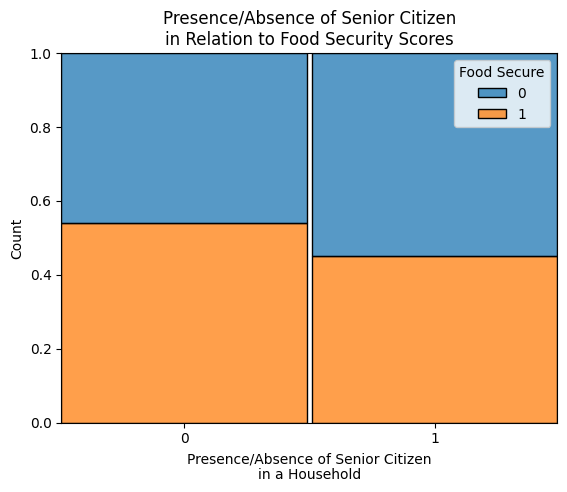

In [30]:
sns.histplot(
    data=t_df,
    x='senior',
    hue='Food Secure',
    multiple='fill',
    shrink=0.98
)
plt.xticks([0,1])
plt.xlabel('Presence/Absence of Senior Citizen\nin a Household')
plt.title('Presence/Absence of Senior Citizen\nin Relation to Food Security Scores')

In [31]:
# chi-squared test of independence between food secure, food insecure, w/ and w/out senior citizen #
s_fs = pd.DataFrame(t_df[['Food Secure','senior']].value_counts()).unstack()
res = stats.contingency.chi2_contingency(s_fs)
print('P-Value (Senior and Food Security): ','%.2f' %res.pvalue)

P-Value (Senior and Food Security):  0.61


### Binary Logistic Regression 
We have established that income, gardens, and presence of minors somewhat influence/move together with food security. The aim of this model is to estimate measures of by how much really do these variables affect food security. I initially plotted a correlation heatmap across different variables, just to see which variables to include/exclude in the model. I opted for `log_income`,`Garden`, and `minor` for my independent variables. Of course, my independent variable is `Food Secure`.

I then split the sample to two: training and testing data. The former will be used to train/construct the model while the latter will be used for evaluating. This is done to avoid overfitting the model which could lead it to perform really well during the evaluation, BUT lack the predicting power when it is exposed to data from outside the training data.

The coefficients for `log_income`, `Garden`, and `minor`, are positive(+), negative(-), and negative(-) respectively. This confirms the initial suspicion that income contributes towards food security, while the presence of gardens and minors in a household leads to food insecurity. More specifically, their marginal effects are (respectively): 0.53, -0.11, and -0.18. In other words, holding other things constant, the presence of garden and minors reduces the probability of being food secure by a corresponding 11 and 18 percent. Meanwhile, an increase in the log income of a household by one unit, on average, adds 53 percent towards their probability of being food secure. 

Assessing the predictive performance of the model, it scored between 0.68 to 0.75 across different metrics. Accuracy, which measures the proportion of true positives and true negatives over total predictions, scored the lowest (at 0.68). On the other hand, precision, which measures the proportion of true positives over true and false positives, scored the highest. In other words, the model is quite strong in predicting true positives, however it seems to err on the side of caution (as supported by weak recall at 0.69) and would rather have false negatives than false positives. This is not 'purely' bad per se; after all, it would make much more sense to _identify_ food insecure households that are (in reality) food secure rather than the alternative which is classifying food insecure households as food secure. The former extends help to those who do _not_ need it while the latter withholds support from those who _do_ need it.

Still, with an F1 score of 0.72, it is an _average_ model which (given the limited data and variables) is not inherently bad nor great.

<Axes: >

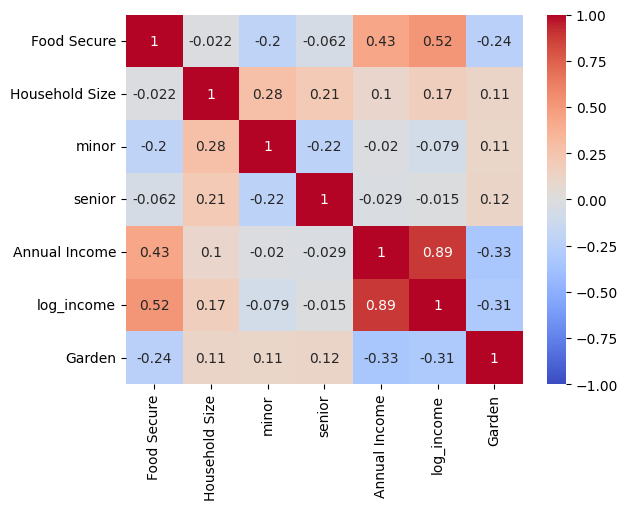

In [33]:
# correlation heatmap for choosing variables to include in regression model #
sns.heatmap(data=t_df.corr(),
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            annot=True
           )

In [34]:
# splitting samples for training and testing model #
y = t_df['Food Secure']
x = t_df[['log_income','Garden','minor']]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30,random_state=42)

# combining data frames for smf #
t_data = pd.concat([y_train, x_train],axis=1)
t_data.columns = ['Food_Secure', 'log_income', 'Garden', 'minor']

In [35]:
logit = smf.logit(
    formula = 'Food_Secure ~ log_income + Garden + minor',
    data = t_data.astype('int')
)
model = logit.fit()
model.summary(alpha=0.10)

Optimization terminated successfully.
         Current function value: 0.595331
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Food_Secure   No. Observations:                  102
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            3
Date:                Wed, 11 Dec 2024   Pseudo R-squ.:                  0.1411
Time:                        22:32:07   Log-Likelihood:                -60.724
converged:                       True   LL-Null:                       -70.701
Covariance Type:            nonrobust   LLR p-value:                 0.0001735
==============================================================================
                 coef    std err          z      P>|z|       [0.05       0.95]
------------------------------------------------------------------------------
Intercept    -11.6661      5.278     -2.211      0.027     -20.347      -2.985
log_income     2.5705      1.047      2.456      0.014       0.849       4.292
Garden        -0.5525      0.444     -1.245      0.213      -1.282       0.177
minor         -0.8866      0.586     -1.513      0.130      -1.850       0.077
==============================================================================
"""

In [36]:
model.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            Food_Secure
Method:                          dydx
At:                           overall
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
log_income     0.5337      0.199      2.676      0.007       0.143       0.925
Garden        -0.1147      0.089     -1.286      0.198      -0.290       0.060
minor         -0.1841      0.116     -1.587      0.112      -0.411       0.043
==============================================================================
"""

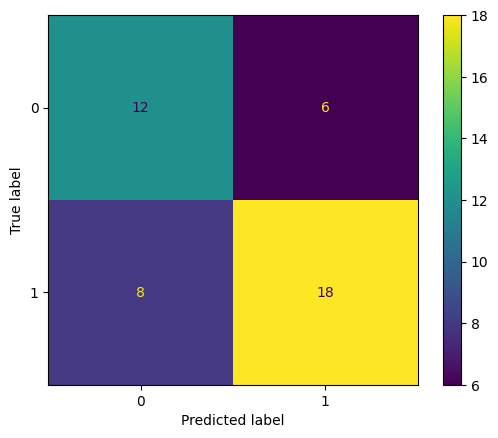

In [37]:
# confusion matrix: logistic regression #
y_pred = round(model.predict(x_test.astype('int')))
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot()

In [38]:
# metrics for logistic regression #
print('Accuracy: ', '%.2f' % metrics.accuracy_score(y_test,y_pred))
print('Precision: ', '%.2f' % metrics.precision_score(y_test,y_pred))
print('Recall: ', '%.2f' % metrics.recall_score(y_test,y_pred))
print('F1 Score: ', '%.2f' % metrics.f1_score(y_test,y_pred))

Accuracy:  0.68
Precision:  0.75
Recall:  0.69
F1 Score:  0.72


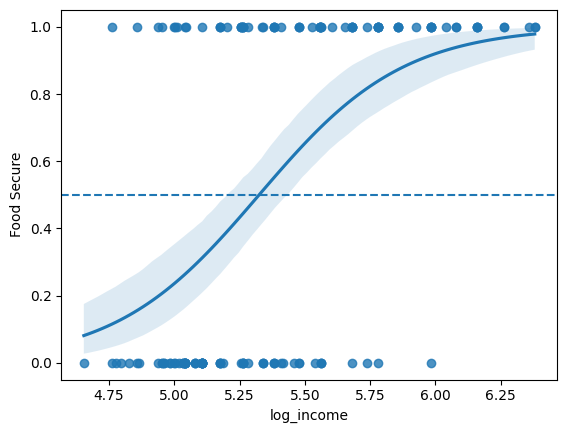

In [39]:
# 2-D plot of logistic regression; x=income, y=food secure #
sns.regplot(
    data=t_df,
    x='log_income',
    y='Food Secure',
    logistic=True
)
plt.axhline(0.5,linestyle='--')

### Decision Trees
#### First Decision Tree
The first decision tree's root node split at income above Php 350,000 which probably makes this an ideal criterion for the next decision tree. Further along the tree, most splits happen across different levels of income which does not really tell us much. As such, I have initialized a new binary/categorical variable which segments the respondents as either having an annual income of 350,000 or not. This will be used for the succeeding decision tree. Metrics for this particular tree are actually worse than the preceeding logistic regression. Scores range between 0.58 to 0.83, with recall being the weakest and precision the strongest. Just like the logistic regression, this particular model would rather mislabel food secure individuals as food insecure rather than the opposite. 

#### Second Decision Tree
For this particular decision tree, `log_income` was replaced with `i>350`, a categorical/binary variable on whether a particular household's annual income is greater than 350,000 pesos or not. Once more, it emphasizes the power that income has over food security wherein it the root node basically splits the entire tree to food secure and food insecure (on whether the household earns 350,000 annually or not). The metrics for this tree are on par (or slightly better) than the logistic regression. Scores ranged between 0.62 to 0.94, with recall (!) being the lowest and precision (!) being the highest. F1 score is slightly higher at 0.74.

In [41]:
# initial decision tree specification#
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(x_train,y_train)
dt_pred = decision_tree.predict(x_test)

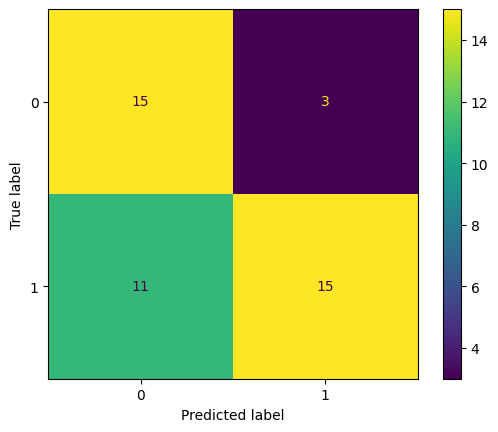

In [42]:
# confusion matrix: decision tree no.1 #
cm = metrics.confusion_matrix(y_test, dt_pred, labels = decision_tree.classes_)
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=decision_tree.classes_)
disp.plot()

In [43]:
# decision tree metrics #
print('Accuracy: ', '%.2f' % metrics.accuracy_score(y_test,dt_pred))
print('Precision: ', '%.2f' % metrics.precision_score(y_test,dt_pred))
print('Recall: ', '%.2f' % metrics.recall_score(y_test,dt_pred))
print('F1 Score: ', '%.2f' % metrics.f1_score(y_test,dt_pred))

Accuracy:  0.68
Precision:  0.83
Recall:  0.58
F1 Score:  0.68


[Text(0.65, 0.9, 'log_income <= 5.547\ngini = 0.5\nsamples = 102\nvalue = [51, 51]\nclass = Food Insecure'),
 Text(0.4, 0.7, 'log_income <= 5.141\ngini = 0.441\nsamples = 67\nvalue = [45, 22]\nclass = Food Insecure'),
 Text(0.525, 0.8, 'True  '),
 Text(0.2, 0.5, 'Garden <= 0.5\ngini = 0.32\nsamples = 35\nvalue = [28, 7]\nclass = Food Insecure'),
 Text(0.1, 0.3, 'log_income <= 4.898\ngini = 0.463\nsamples = 11\nvalue = [7, 4]\nclass = Food Insecure'),
 Text(0.05, 0.1, '\n  (...)  \n'),
 Text(0.15, 0.1, '\n  (...)  \n'),
 Text(0.3, 0.3, 'log_income <= 5.061\ngini = 0.219\nsamples = 24\nvalue = [21, 3]\nclass = Food Insecure'),
 Text(0.25, 0.1, '\n  (...)  \n'),
 Text(0.35, 0.1, '\n  (...)  \n'),
 Text(0.6, 0.5, 'log_income <= 5.337\ngini = 0.498\nsamples = 32\nvalue = [17, 15]\nclass = Food Insecure'),
 Text(0.5, 0.3, 'log_income <= 5.309\ngini = 0.494\nsamples = 18\nvalue = [8, 10]\nclass = Food Secure'),
 Text(0.45, 0.1, '\n  (...)  \n'),
 Text(0.55, 0.1, '\n  (...)  \n'),
 Text(0.7, 0

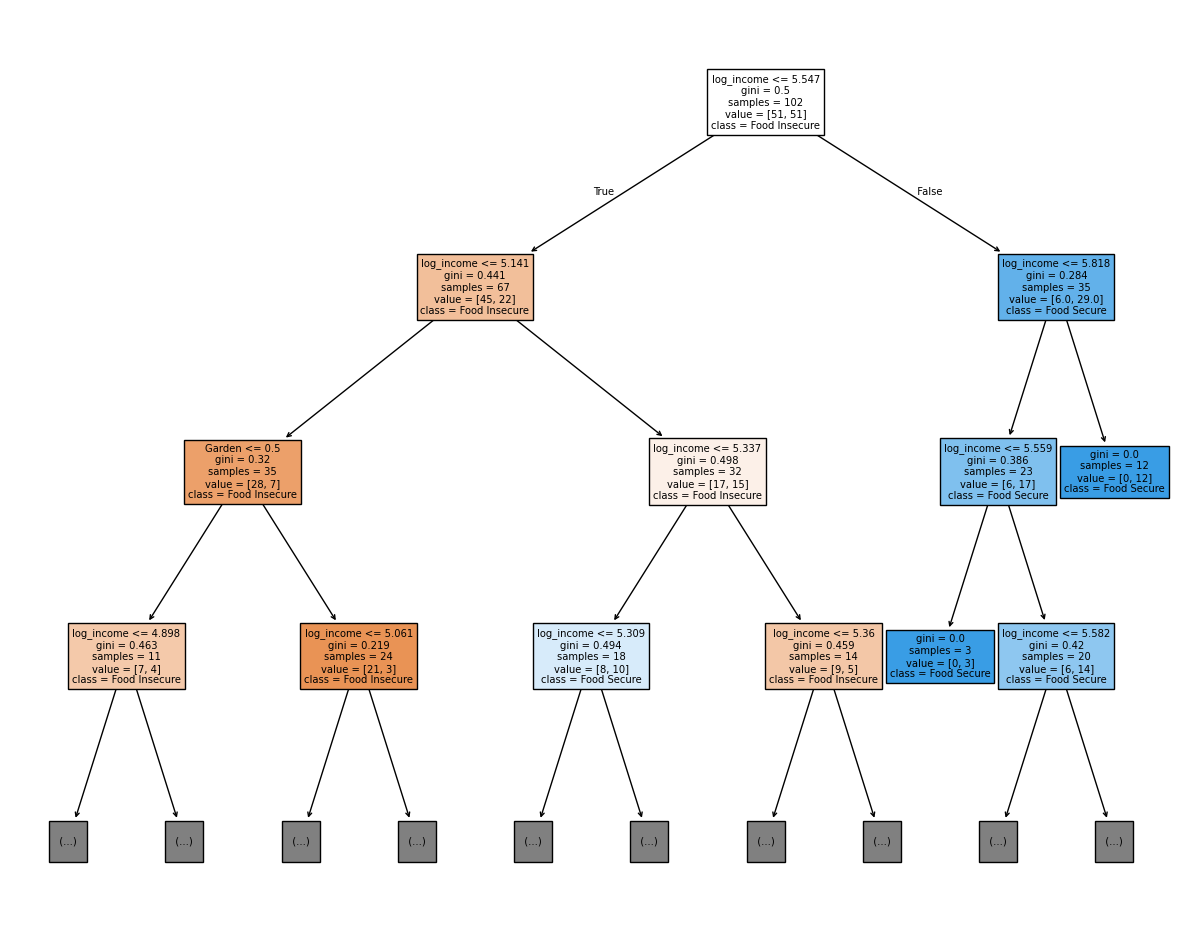

In [44]:
# decision tree #
plt.figure(figsize=(15,12))
plot_tree(decision_tree, feature_names=x.columns, max_depth = 3,
          class_names={0:'Food Insecure', 1:'Food Secure'}, filled=True)

In [45]:
# transform income to dummy: above 350k and below #
t_df['i>350'] = np.where(t_df['Annual Income']>350000,1,0)

C:\Users\Barba\AppData\Local\Temp\ipykernel_14116\1525110532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['i>350'] = np.where(t_df['Annual Income']>350000,1,0)


In [46]:
# 'improved' decision tree specification #
y = t_df['Food Secure']
x = t_df[['i>350','Garden','minor']]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30,random_state=42)

decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(x_train,y_train)
dt_pred = decision_tree.predict(x_test)

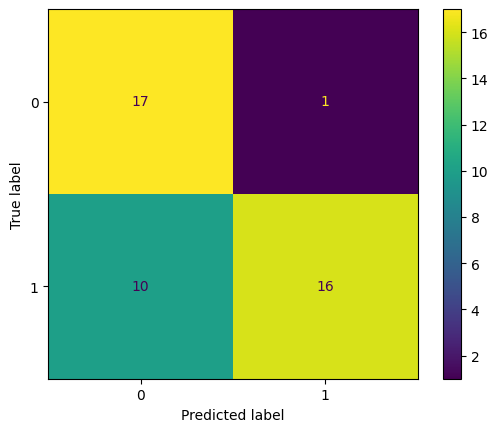

In [47]:
# confusion matrix: decision tree no.2 #
cm = metrics.confusion_matrix(y_test, dt_pred, labels = decision_tree.classes_)
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=decision_tree.classes_)
disp.plot()

In [48]:
# metrics for decision tree no. 2 #
print('Accuracy: ', '%.2f' % metrics.accuracy_score(y_test,dt_pred))
print('Precision: ', '%.2f' % metrics.precision_score(y_test,dt_pred))
print('Recall: ', '%.2f' % metrics.recall_score(y_test,dt_pred))
print('F1 Score: ', '%.2f' % metrics.f1_score(y_test,dt_pred))

Accuracy:  0.75
Precision:  0.94
Recall:  0.62
F1 Score:  0.74


[Text(0.5, 0.875, 'i>350 <= 0.5\ngini = 0.5\nsamples = 102\nvalue = [51, 51]\nclass = Food Insecure'),
 Text(0.25, 0.625, 'Garden <= 0.5\ngini = 0.441\nsamples = 67\nvalue = [45, 22]\nclass = Food Insecure'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'minor <= 0.5\ngini = 0.494\nsamples = 27\nvalue = [15, 12]\nclass = Food Insecure'),
 Text(0.0625, 0.125, 'gini = 0.48\nsamples = 5\nvalue = [2, 3]\nclass = Food Secure'),
 Text(0.1875, 0.125, 'gini = 0.483\nsamples = 22\nvalue = [13, 9]\nclass = Food Insecure'),
 Text(0.375, 0.375, 'minor <= 0.5\ngini = 0.375\nsamples = 40\nvalue = [30, 10]\nclass = Food Insecure'),
 Text(0.3125, 0.125, 'gini = 0.444\nsamples = 3\nvalue = [2, 1]\nclass = Food Insecure'),
 Text(0.4375, 0.125, 'gini = 0.368\nsamples = 37\nvalue = [28, 9]\nclass = Food Insecure'),
 Text(0.75, 0.625, 'Garden <= 0.5\ngini = 0.284\nsamples = 35\nvalue = [6.0, 29.0]\nclass = Food Secure'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'minor <= 0.5\ngini = 0.198\ns

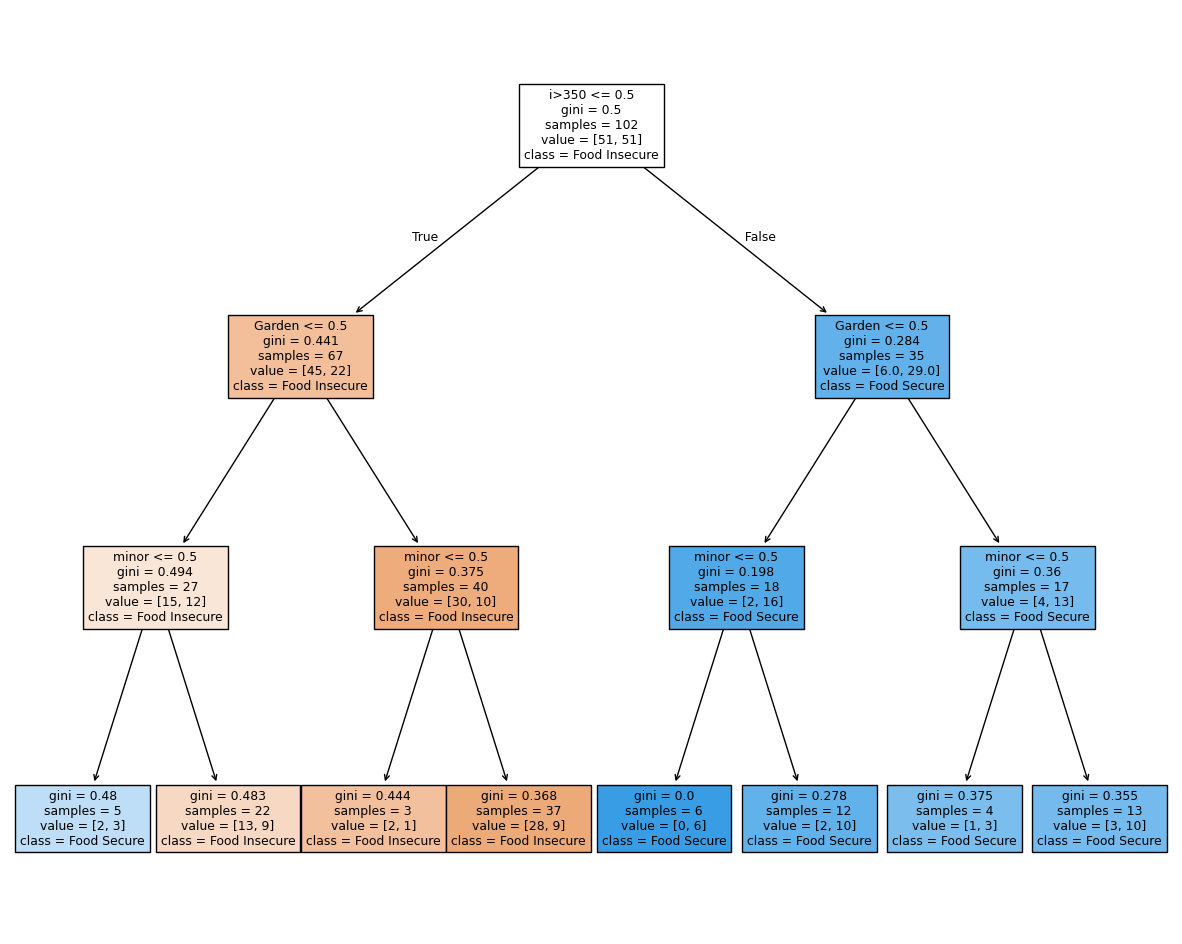

In [49]:
# decision tree no. 2 #
plt.figure(figsize=(15,12))
plot_tree(decision_tree, feature_names=x.columns, 
          class_names={0:'Food Insecure', 1:'Food Secure'}, filled=True)

### Conclusion and Final Words
If you've read this far, thank you! The main objective of this study was to really identify whether gardens contribute towards achieving food security; most especially now that there is an interest towards more sustainable alternatives to conventional food production systems. Unfortunately, that was not the case here HOWEVER, that does not mean that no valuable insights were generated within this study.

1. Firstly, gardens could prove to be a _useful_ indicator in identifying at-risk households. If you see multiple households doing/practicing gardening, it might be akin to a distress signal that the populace is unable to access food and no alternatives (e.g. employment) are present, which makes them resort to gardening.

2. Money might not buy happiness (at a certain point), but the data here most likely suggests it contributes towards food security. Not reiventing the wheel of classical economics; an increase of income through job creation/employment could prove to be a potent ward against food insecurity.

3. Finally, the presence of minors endangers the food security of households (with low-income households being the most vulnerable). Growing income is not enough; capabilities, opportunities, and choices must also be expanded. Education not only leads to employment; it also enables better and more informed decisions. Open-information and broadening the accessibility of birth control methods might help avoid food insecurity.

These recommendations might not be the most revolutionary/ground-breaking in the world, but it certainly reminds us that we do not necessarily need to reinvent the wheel and that the 'simplest' and most obvious solutions might also be the hardest/most complex to implement; if it was so simple, it would have already been done.